# Digital House - Data Science a Distancia

## Trabajo Práctico 2



### Autores: Daniel Borrino, Ivan Mongi, Jessica Polakoff, Julio Tentor

<p style="text-align:right;">Mayo 2022</p>

#### Aspectos técnicos
La notebook se ejecuta correctamente en una instalación estándar de Anaconda versión 4.11.0 build  3.21.6, Python 3.9.7


#### Librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
import statsmodels.api as sm

In [5]:
# Ignore some warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

---
#### Dataset

In [6]:
data_final_url = "../Data/properatti_final5.csv"
data = pd.read_csv(data_final_url, encoding="utf-8")


---
#### Seleccionar, renombrar y ajustar valores de las características

In [7]:
if 'Unnamed: 0' in list(data.columns) :
    data = data.drop(columns=['Unnamed: 0']).copy()

In [9]:
data.rename(columns={'property_type' : 'tipo'}, inplace=True)
data.rename(columns={'price_aprox_usd' : 'precio'}, inplace=True)
data.rename(columns={'surface_covered_in_m2' : 'superficie'}, inplace=True)

In [10]:
# Trabajar con precio en miles de dólares
data['precio'] = (data['precio'] / 1000).round(3)

In [11]:
# Ajustar la cantidad de ambientes de [1, 7 o más]
data['ambientes'] = data['ambientes'].apply(lambda x : x if x < 7 else 7) 

In [12]:
# Ajustar la cantidad de baños de [1, 3 o más]
data['baños'] = data['baños'].apply(lambda x : x if x < 3 else 3)

---
#### Dummies

In [13]:
dummies = pd.get_dummies(data=data['tipo'], drop_first=True)
dummies.index = data.index
data = pd.concat([data, dummies], axis=1)

---

In [14]:
data.shape

(45578, 18)

In [15]:
data.head()

,tipo,place_name,state_name,precio,superficie,ambientes,baños,balcón,cochera,parrilla,pileta,amoblado,lavadero,patio,terraza,jardin,apartment,house
0,apartment,Mataderos,Capital Federal,72.0,55.0,2.0,1.0,0,0,0,0,0,1,0,0,0,1,0
1,PH,Munro,Bs.As. G.B.A. Zona Norte,130.0,78.0,1.0,1.0,0,0,0,0,0,1,1,0,0,0,0
2,apartment,Belgrano,Capital Federal,138.0,40.0,1.0,1.0,0,0,0,1,0,0,0,0,0,1,0
3,apartment,Belgrano,Capital Federal,195.0,60.0,1.0,1.0,0,0,0,1,0,0,0,0,0,1,0
4,apartment,Palermo Soho,Capital Federal,111.7,30.0,1.0,1.0,1,0,0,1,0,0,0,1,0,1,0


---


In [16]:

sns.set()
plt.style.use('seaborn')

sns.mpl.rcParams['axes.titlesize'] = 20
sns.mpl.rcParams['axes.labelsize'] = 16


In [17]:
features = ['apartment', 'house', 'superficie',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']
target = 'precio'

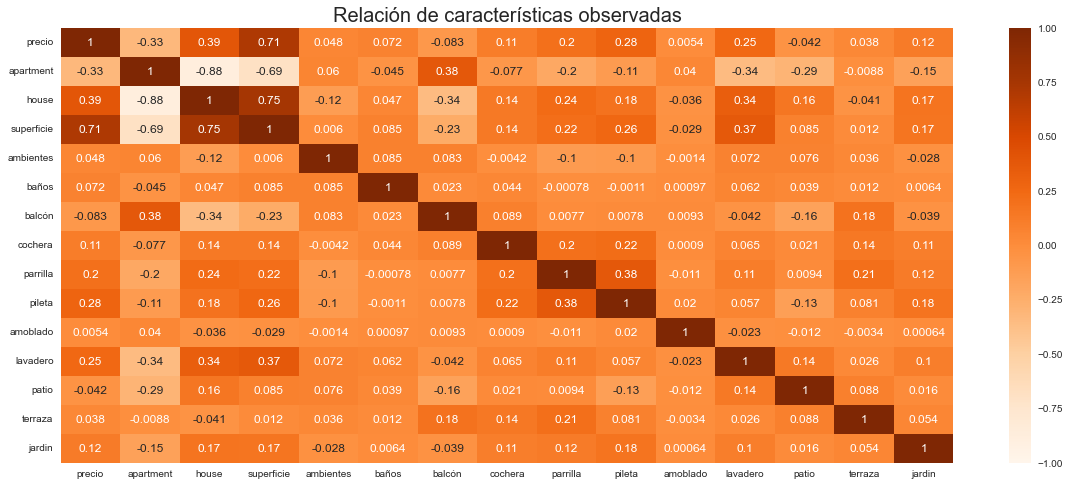

In [18]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(data[[target] + features].corr(), annot=True, vmin=-1, vmax=1, cmap='Oranges', ax=ax)
ax.set(title='Relación de características observadas')
plt.show()

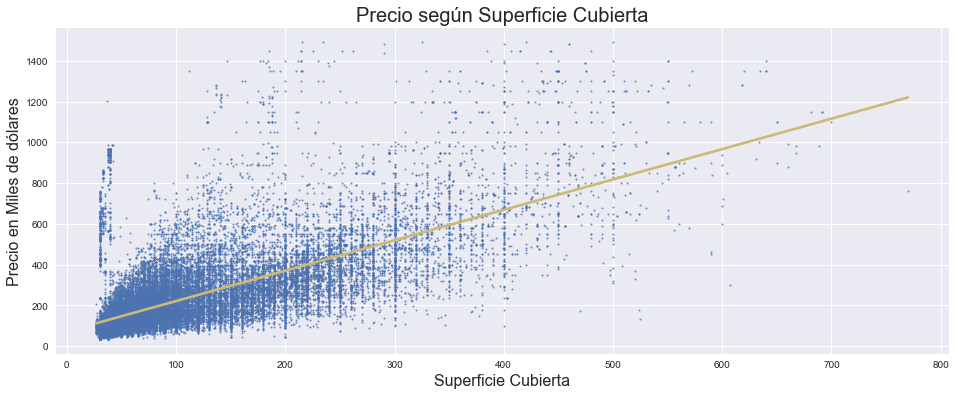

In [19]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.regplot(data=data, x='superficie', y='precio', ci=None, color='y', scatter_kws={'color':'b', 's':4}, ax=ax)
ax.set(title='Precio según Superficie Cubierta', 
       ylabel='Precio en Miles de dólares', 
       xlabel='Superficie Cubierta')
plt.show()

---
#### Variables calculadas

In [20]:
data['logsuperficie'] = np.log(data['superficie'])

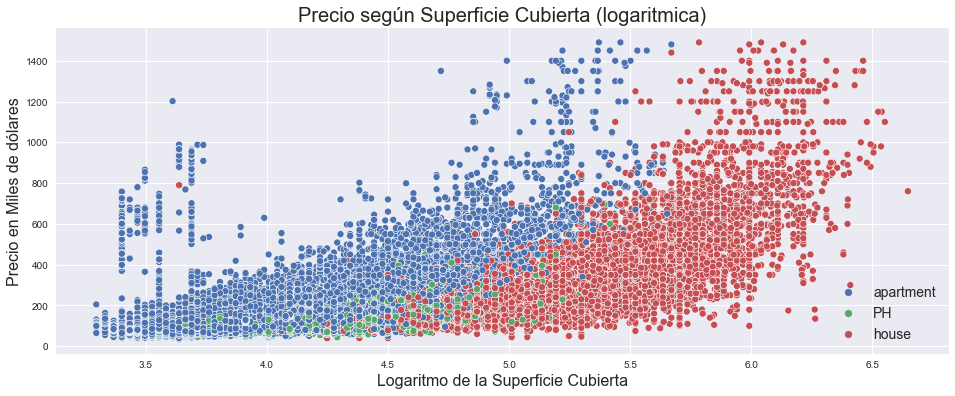

In [21]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.scatterplot(data=data, x='logsuperficie', y='precio', ci=None, hue='tipo', ax=ax)
ax.set(title='Precio según Superficie Cubierta (logaritmica)', 
       ylabel='Precio en Miles de dólares', 
       xlabel='Logaritmo de la Superficie Cubierta')
plt.legend(loc='lower right', fontsize=14)
plt.show()

---



In [22]:
def r2_adjust(r2, n, p) :
    u''' Calculate R^2 adjusted for n observations and p grades of freedom '''
    return (1 - (1 - r2) * ((n - 1) / (n - p - 1) ))

In [23]:
def train_LinearRegression(X, y) :
    u""" Performs Ordinary Least Squares linear regression from Scikit-Learn linear models

    Args:
        * X array of array of features values
        * y array of target values
    Returns:
        a model fit objetct and a dataframe with metrics; MAE sqrt MSE, ^2 adj

    """
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
    
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain, ytrain)
    ymodel = model.predict(Xtrain)
    ypred = model.predict(Xtest)
    
    df = pd.DataFrame()
    df = pd.concat([df, pd.DataFrame(columns=['Features'], data=[ str(list(X.columns)) ])], axis=1)

    df = pd.concat([df, pd.DataFrame(columns=['MAE'], data=[ mean_absolute_error(ytest, ypred).round(3) ])], axis=1)
    df = pd.concat([df, pd.DataFrame(columns=['sqrt MSE'], data=[ np.sqrt(mean_squared_error(ytest, ypred)).round(3) ])], axis=1)

    r2_train = (1 - (1 - r2_score(ytrain, ymodel)) * ((len(ytrain) - 1) / (len(ytrain) - len(X.columns) - 1) )).round(3)
    
    df = pd.concat([df, pd.DataFrame(columns=['R^2 adj train'], data=[ r2_train ])], axis=1)

    #r2_test = (1 - (1 - r2_score(ytest, ypred)) * ((len(ytest) - 1) / (len(ytest) - len(X.columns) - 1) )).round(3)
    r2_test = r2_adjust(r2_score(ytest, ypred), len(ytest), len(X.columns))
    df = pd.concat([df, pd.DataFrame(columns=['R^2 adj test'], data=[ r2_test ])], axis=1)
    
    return model, df, Xtest, ytest


---
### Train models


In [24]:

y = data['precio']
metrics = pd.DataFrame()

data['s2'] = data['logsuperficie'] ** 2
data['s3'] = data['logsuperficie'] ** 3
data['s4'] = data['logsuperficie'] ** 4
data['s5'] = data['logsuperficie'] ** 5


In [25]:

features = ['apartment', 'house', 'superficie', 'logsuperficie',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [26]:

features = ['apartment', 'house', 'superficie', 'logsuperficie',
            's2',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [27]:

features = ['apartment', 'house', 'superficie', 'logsuperficie',
            's2', 's3',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [28]:

features = ['apartment', 'house', 'superficie', 'logsuperficie',
            's2', 's3', 's4',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [29]:

features = ['apartment', 'house', 'superficie', 'logsuperficie',
            's2', 's3', 's4', 's5',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


---

In [30]:
pd.options.display.max_colwidth = 120

In [31]:
display(metrics.head(20))

,Features,MAE,sqrt MSE,R^2 adj train,R^2 adj test
0,"['apartment', 'house', 'superficie', 'logsuperficie', 'ambientes', 'baños', 'balcón', 'cochera', 'parrilla', 'pileta...",71.884,118.763,0.570,0.572254
0,"['apartment', 'house', 'superficie', 'logsuperficie', 's2', 'ambientes', 'baños', 'balcón', 'cochera', 'parrilla', '...",72.188,118.045,0.574,0.577377
0,"['apartment', 'house', 'superficie', 'logsuperficie', 's2', 's3', 'ambientes', 'baños', 'balcón', 'cochera', 'parril...",72.018,117.074,0.582,0.584263
0,"['apartment', 'house', 'superficie', 'logsuperficie', 's2', 's3', 's4', 'ambientes', 'baños', 'balcón', 'cochera', '...",71.989,117.013,0.582,0.584660
0,"['apartment', 'house', 'superficie', 'logsuperficie', 's2', 's3', 's4', 's5', 'ambientes', 'baños', 'balcón', 'coche...",72.170,116.934,0.584,0.585181


In [32]:

ols = sm.OLS(y, sm.add_constant(X)).fit()

display(ols.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precio   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     3382.
Date:                Sun, 01 May 2022   Prob (F-statistic):               0.00
Time:                        11:37:36   Log-Likelihood:            -2.8228e+05
No. Observations:               45578   AIC:                         5.646e+05
Df Residuals:                   45558   BIC:                         5.648e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.079e+05   1.74e+04    -11.929      0.000   -2.42e+05   -1.74e+05
apartment        84.6736      2.717     31.160      0.000      79.347      90.000
house           -97.0629      3.129    -31.021      0.000    -103.196     -90.930
superficie     -204.1646     14.193    -14.385      0.000    -231.983    -176.346
logsuperficie  2.621e+05   2.09e+04     12.515      0.000    2.21e+05    3.03e+05
s2            -1.315e+05   1.01e+04    -13.025      0.000   -1.51e+05   -1.12e+05
s3              3.32e+04   2465.747     13.466      0.000    2.84e+04     3.8e+04
s4            -4226.2936    305.768    -13.822      0.000   -4825.605   -3626.983
s5              226.0006     16.013     14.113      0.000     194.614     257.387
ambientes         0.2816      0.521      0.540      0.589      -0.740       1.303
baños            -8.3526      2.847     -2.934      0.003     -13.932      -2.773
balcón           -0.5627      1.266     -0.444      0.657      -3.044       1.919
cochera          -2.9529      1.182     -2.498      0.012      -5.270      -0.636
parrilla         17.5518      1.295     13.553      0.000      15.014      20.090
pileta           30.1407      1.367     22.054      0.000      27.462      32.819
amoblado         43.6039      7.792      5.596      0.000      28.332      58.876
lavadero          2.5593      1.290      1.985      0.047       0.032       5.087
patio           -20.2126      1.693    -11.938      0.000     -23.531     -16.894
terraza           3.3791      1.320      2.560      0.010       0.792       5.966
jardin            1.7930      2.029      0.884      0.377      -2.183       5.769
==============================================================================
Omnibus:                    27675.825   Durbin-Watson:                   1.510
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           443350.289
Skew:                           2.644   Prob(JB):                         0.00
Kurtosis:                      17.335   Cond. No.                     1.47e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# departamento de 1 m2 cubierto sin cochera ni pileta
#import math
#my_X = [[70, 70*70, 0, 0]]
#my_y = model.predict(my_X)[0]
#display(my_y, math.exp(my_y))

---
### Gauss-Markov


In [34]:
# CUIDADO !!! con un dataset grande demora mucho tiempo
def gauss_markov_test(Xtest, ytest):
    u"""
    funcion para visualizar e identificar supuestos de linealidad sobre la regression lineal
    
    Args:
    * Xtest - bserverd features
    * ytest - observed values
    """

    model = sm.OLS(ytest, sm.add_constant(Xtest)).fit()
    ypred = model.predict()
    resid = model.resid
    rstud = model.get_influence().resid_studentized_internal
    rsqrt = np.sqrt(np.abs(rstud))

    
    plt.figure(figsize=(16, 6))
    sns.regplot(x=ypred, y=ytest, lowess=True, line_kws={'color': 'red'})
    plt.title('Linealidad de Valores Observados', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Valores Observados', fontdict = {'fontsize': 14})
    plt.show()

    plt.figure(figsize=(16, 6))
    sns.regplot(x = ypred, y = resid, lowess = True, line_kws = {'color': 'red'})
    plt.title('Linealidad de Residuos', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Residuos', fontdict = {'fontsize': 14})
    plt.show()
    
    plt.figure(figsize=(16, 8))
    sns.regplot(x = ypred, y = rsqrt, lowess = True, line_kws = {'color': 'red'})
    plt.title('Scale Location', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Residuos Normalizados', fontdict = {'fontsize': 14})
    plt.show()

    
    sns.mpl.rcParams['figure.figsize'] = (16, 8)
    fig, ax = plt.subplots(2)

    sm.graphics.tsa.plot_acf(x = resid, ax = ax[0], lags = 40 , alpha = 0.05, title = '')
    ax[0].set_title('Correlación de características', fontdict = {'fontsize': 18})

    plt.subplots_adjust(top=1.5, wspace=2)

    sm.ProbPlot(model.resid).qqplot(ax = ax[1], line = 's')
    ax[1].set_title('Normalidad de los Residuos', fontdict = {'fontsize': 18})
    ax[1].set_xlabel("Valores Teóricos", fontsize = 14)
    ax[1].set_ylabel("Valores Reales", fontsize = 14)
    plt.show()
    
    return


In [35]:
# CUIDADO !!! con un dataset grande demora mucho tiempo
#gauss_markov_test(Xtest, ytest)

---